# This Project is about Wildfire Detection

In [ ]:
# import required library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE

## Step 1: Data Overview

In [ ]:
# Load your dataset
df = pd.read_csv('/content/synthetic_wildfire_data.csv')  # Adjust path if needed

In [ ]:
# Basic Info
print("Shape:", df.shape)

Shape: (7999, 17)


In [ ]:
print("Columns:", df.columns.tolist())

Columns: ['latitude', 'longitude', 'timestamp', 'ir_band_1', 'ir_band_2', 'ir_band_3', 'temperature', 'vegetation_index', 'wind_speed', 'wind_direction', 'humidity', 'elevation', 'slope', 'land_use', 'distance_to_urban', 'cloud_cover', 'fire_detected']


In [ ]:
print("Data Types:\n", df.dtypes)

Data Types:
 latitude             float64
longitude            float64
timestamp             object
ir_band_1            float64
ir_band_2            float64
ir_band_3            float64
temperature          float64
vegetation_index     float64
wind_speed           float64
wind_direction       float64
humidity             float64
elevation            float64
slope                float64
land_use              object
distance_to_urban    float64
cloud_cover          float64
fire_detected          int64
dtype: object


In [ ]:
print("Basic Statistics:", df.describe(include='all'))

Basic Statistics:            latitude    longitude         timestamp    ir_band_1    ir_band_2  \
count   7999.000000  7999.000000              7999  7999.000000  7999.000000   
unique          NaN          NaN              7937          NaN          NaN   
top             NaN          NaN  28-03-2022 23:27          NaN          NaN   
freq            NaN          NaN                 2          NaN          NaN   
mean      -0.365650    -1.288231               NaN    36.510214    64.605959   
std       52.231873   103.781112               NaN    32.126231    46.106082   
min      -89.990491  -179.982675               NaN     0.014488     0.015774   
25%      -46.247262   -91.846694               NaN    15.065296    28.733460   
50%       -0.969044    -2.490751               NaN    29.669511    58.041002   
75%       45.565455    88.030582               NaN    44.304869    88.400523   
max       89.977297   179.963886               NaN   149.991198   199.753763   

          ir_band_3  

In [ ]:
# check null value
print(" Null Values:", df.isnull().sum())

 Null Values: latitude             0
longitude            0
timestamp            0
ir_band_1            0
ir_band_2            0
ir_band_3            0
temperature          0
vegetation_index     0
wind_speed           0
wind_direction       0
humidity             0
elevation            0
slope                0
land_use             0
distance_to_urban    0
cloud_cover          0
fire_detected        0
dtype: int64


## Step 2: Data Preprocessing

### Data Cleaning

In [ ]:
# Drop timestamp as it's not useful for prediction
df.drop(columns=['timestamp'], inplace=True)

# Convert land_use (categorical) to numerical using category encoding
df['land_use'] = df['land_use'].astype('category').cat.codes


###  Outlier Treatment

In [ ]:
# Replace extreme values with column mean
for col in df.select_dtypes(include='number').columns:
    mean = df[col].mean()
    std = df[col].std()
    upper = mean + 3 * std
    lower = mean - 3 * std
    df[col] = np.where((df[col] > upper) | (df[col] < lower), mean, df[col])


## Step 3: Exploratory Data Analysis (EDA)

### Univariate Analysis

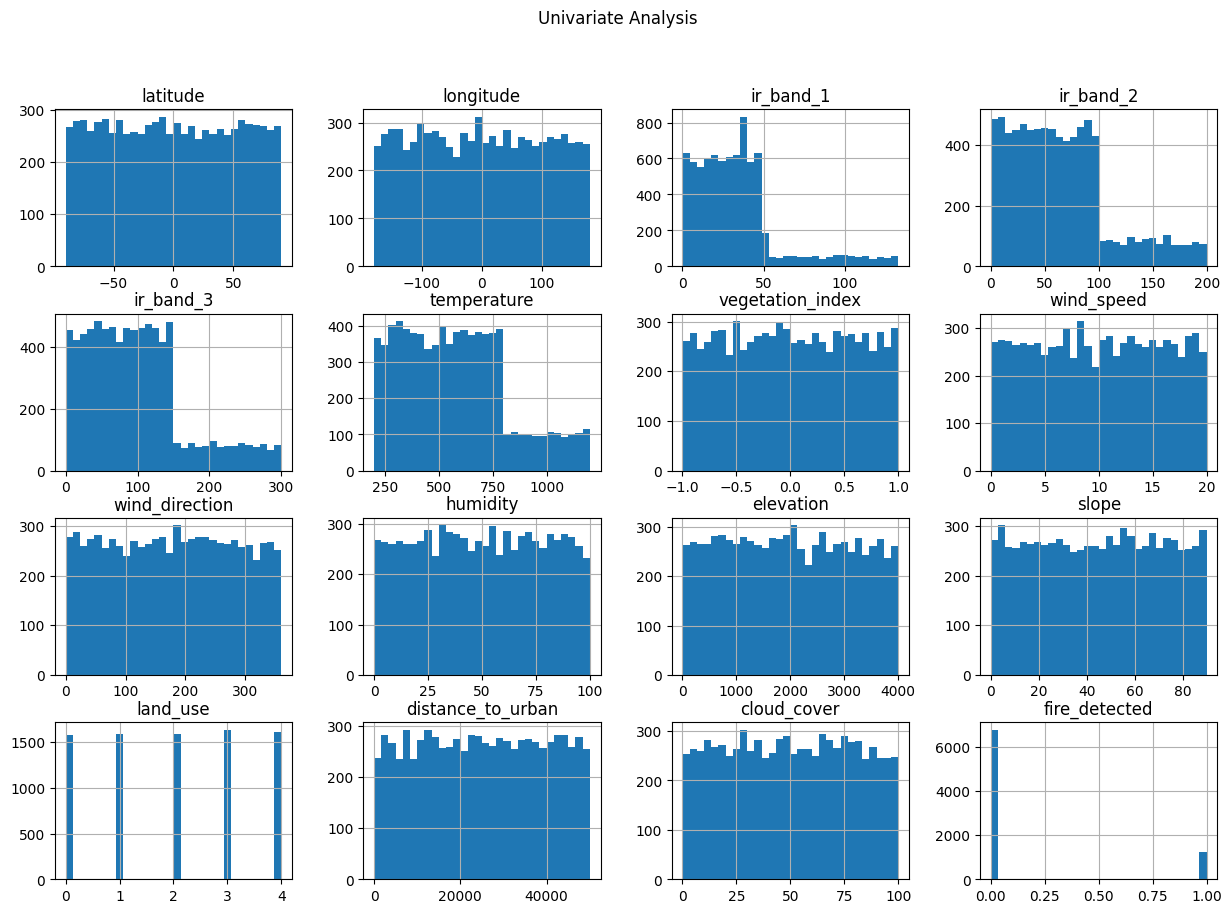

In [ ]:
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Univariate Analysis")
plt.show()


###Bivariate Analysis

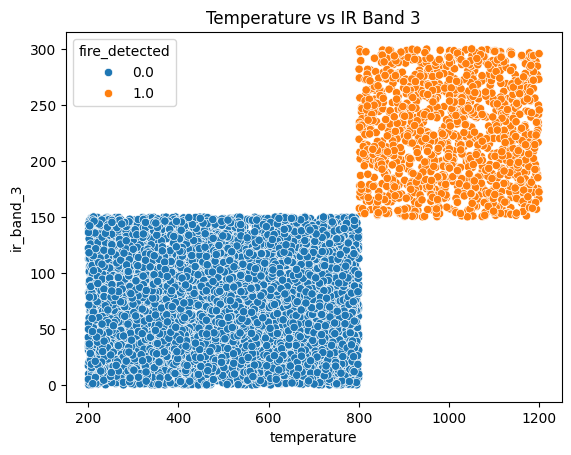

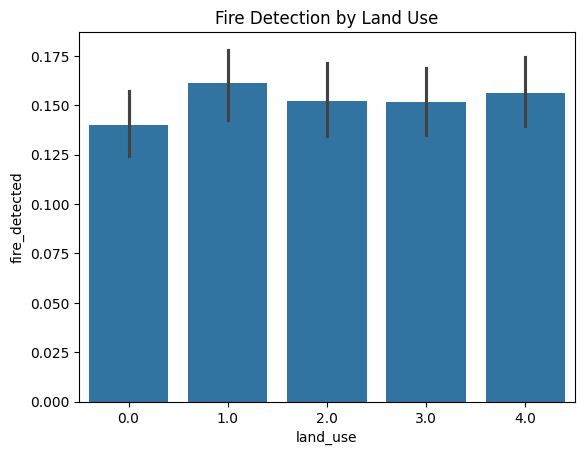

In [ ]:
# Scatter for numerical-numerical
sns.scatterplot(data=df, x='temperature', y='ir_band_3', hue='fire_detected')
plt.title("Temperature vs IR Band 3")
plt.show()

# Bar plot for categorical-numerical
sns.barplot(data=df, x='land_use', y='fire_detected')
plt.title("Fire Detection by Land Use")
plt.show()


### Correlation Matrix

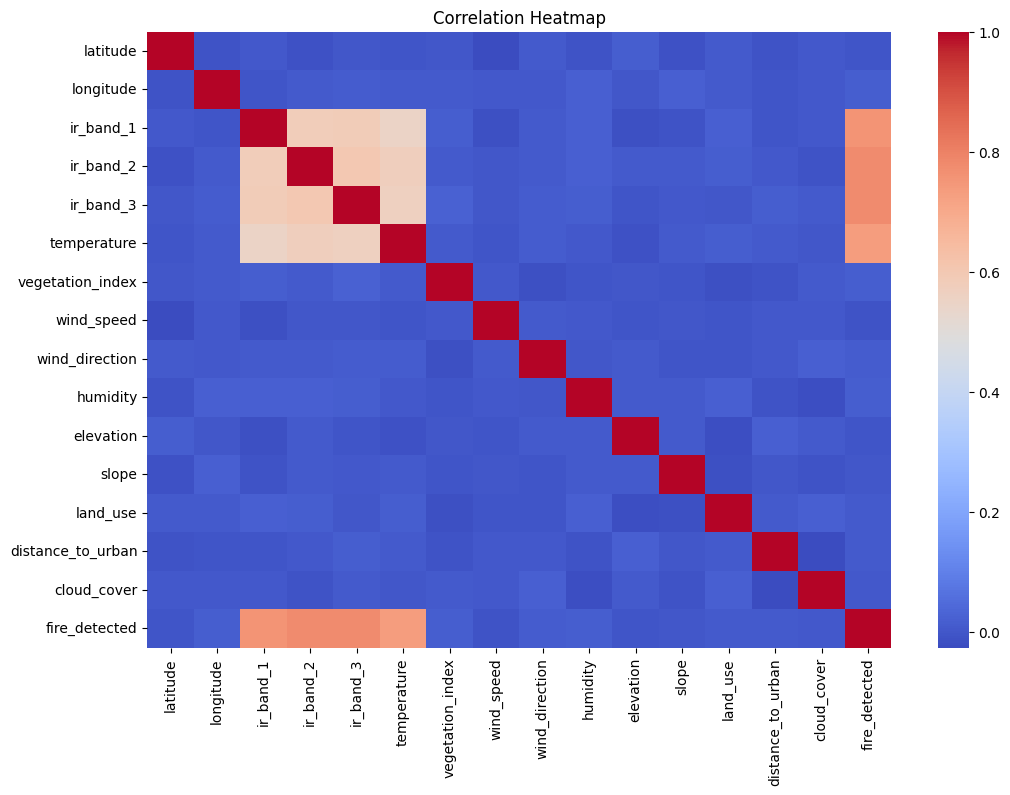

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm')  # removed annot=True
plt.title("Correlation Heatmap")
plt.show()


## Step 4: Data Preparation for ML

### Splitting Features and Target

In [ ]:
X = df.drop('fire_detected', axis=1)
y = df['fire_detected']


### Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Step 5: Base Model Training

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1336    0]
 [   0  264]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1336
         1.0       1.00      1.00      1.00       264

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



## step-6 perform hyper perameter tunning using cross validation


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_


Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


##  Step 7: Feature Selection using RFE

In [ ]:
selector = RFE(RandomForestClassifier(), n_features_to_select=8)
selector.fit(X_train_scaled, y_train)

selected_features = X.columns[selector.support_]
print("Selected Features:\n", selected_features)


Selected Features:
 Index(['latitude', 'ir_band_1', 'ir_band_2', 'ir_band_3', 'temperature',
       'wind_speed', 'elevation', 'slope'],
      dtype='object')


In [ ]:
# Example: replace values with user input (must match original column order)
new_data = [[
    12.5,          # latitude
    77.5,          # longitude
    35.5,          # ir_band_1
    62.3,          # ir_band_2
    90.1,          # ir_band_3
    550.2,         # temperature
    0.12,          # vegetation_index
    10.0,          # wind_speed
    180.0,         # wind_direction
    45.0,          # humidity
    1000.0,        # elevation
    20.0,          # slope
    1,             # land_use (use encoded number)
    25000.0,       # distance_to_urban
    50.0           # cloud_cover
]]


In [ ]:
# Scale the new input
new_data_scaled = scaler.transform(new_data)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Predict
prediction = model.predict(new_data_scaled)
probability = model.predict_proba(new_data_scaled)

# Output
print("Fire Detected (1 = Yes, 0 = No):", prediction[0])
print("Probability [No Fire, Fire]:", probability[0])


Fire Detected (1 = Yes, 0 = No): 0.0
Probability [No Fire, Fire]: [1. 0.]


In [ ]:
# Predict
prediction = model.predict(new_data_scaled)
probability = model.predict_proba(new_data_scaled)

# Output
print("Fire Detected (1 = Yes, 0 = No):", prediction[0])
print("Probability [No Fire, Fire]:", probability[0])


Fire Detected (1 = Yes, 0 = No): 0.0
Probability [No Fire, Fire]: [1. 0.]


In [ ]:
# Predict
prediction = model.predict(new_data_scaled)
probability = model.predict_proba(new_data_scaled)

# Output
print("Fire Detected (1 = Yes, 0 = No):", prediction[0])
print("Probability [No Fire, Fire]:", probability[0])


Fire Detected (1 = Yes, 0 = No): 0.0
Probability [No Fire, Fire]: [1. 0.]
